# Data Normalisation
Here, we want to normalise our data by common quantile scaling.
To do so, we will merge the T-Digests of each `EOPatch` from our training set.
Based on that, we will store the desired quantiles for data normalisation.

In [1]:
### Michael Engel ### 2022-04-25 ### main.ipynb ###
### adapted by Niklas Eisl, Colin Moldenhauer, 2022/23 ###
import os
import platform
import numpy as np
import matplotlib.pyplot as plt
import time

from eolearn.core import FeatureType

from libs.ConfigME import Config, get_most_recent_config
from libs.MergeTDigests import mergeTDigests
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from libs.Dataset_eolearn import Torchify

print("Working Directory:",os.getcwd())

# Config
First, we load our configuration file which provides all information we need throughout the script.

In [2]:
 #%% load configuration file
config_name = get_most_recent_config(".", pattern="config_.*[.]dill", mode="m")
config = Config.LOAD(config_name)
print("loaded config:", config_name)

# Merge T-Digests
Before we can do the normalisation of our dataset, we need to access the distribution of the data.
The T-Digests can approximate cumulative distribution functions (CDF) without having the whole dataset in memory.
Accordingly, we can approximate the desired quantiles for normalisation.

In [3]:
start = time.time()
tdigest = mergeTDigests(
    paths = [os.path.join(config["dir_train"], dir_) for dir_ in os.listdir(config["dir_train"])],
    feature = (FeatureType.SCALAR_TIMELESS, "tdigest_data"),
    threads = 0 if platform.system()=="Windows" else config["threads"],
    checkthreads = True,
    bequiet = False
)
print(f"Merging of T-Digests took {time.time()-start:.2f}s using {config['threads']} thread(s)!")

# Analyse T-Digests
Let's compute some quantiles for plotting the CDFs!

In [4]:
quantile_list = []
cdf_list = []
for tdigest_band in tdigest:
    qu = np.array([tdigest_band.percentile(_) for _ in np.linspace(0, 100, 100)])
    cdf = np.array([tdigest_band.cdf(_) for _ in qu])

    quantile_list.append(qu)
    cdf_list.append(cdf)

We see that the input bands live in different ranges.
Hence, it is crucial for machine learning to normalise both.
For that purpose, we store the T-Digest to disk for later usage in our ML pipeline!

In [5]:
np.save(os.path.join(config["dir_results"], config["savename_tdigest"]), tdigest)

# Quantile Scaling
As discussed, we want to apply quantile scaling to our data.
We already merged the separate T-Digests to one and stored the result to disk.
Note that only the training samples have been used for that.

Since PyTorch asks for the shape `[batch_size x channels x timestamps x height x width]`, we need to reshape the data features accordingly.
Fortunately, the `QuantileScaler_eolearn_tdigest` can handle this by setting `transform=True`.
However, we do not need a temporal component - neither for the input data nor the reference.
Hence, we will use the class `Torchify` itself as provided from the `Dataset_eolearn` package which allows to squeeze the temporal dimension.

In [6]:
Scaler = QuantileScaler_eolearn_tdigest(
    tdigestarray = tdigest,
    minquantile = config["scaler_minquantile"],
    maxquantile = config["scaler_maxquantile"],
    nanval = config["scaler_nanval"],
    infval = config["scaler_infval"],
    valmin = config["scaler_valmin"],
    valmax = config["scaler_valmax"],
    transform = Torchify(1),
    savename = os.path.join(config["dir_results"], config["savename_scaler"])
)

Let's see whether it works!
First, we have to transform our quantiles.
Note that this transformation is a bit hacky as we do not have height nor width as we would for our `EOPatches`.

In [7]:
quantiles = np.stack(quantile_list, axis=-1)
quantiles_transformed = Scaler(quantiles)

Let's have a look at the resulting CDFs!
For the sake of clarity, we will have a look at a 96%-interval, namely from the 2% to the 98% quantile.

Let's visualise our numeric window in the distribution of our data!

Text(0.5, 0.49, 'Transformed')

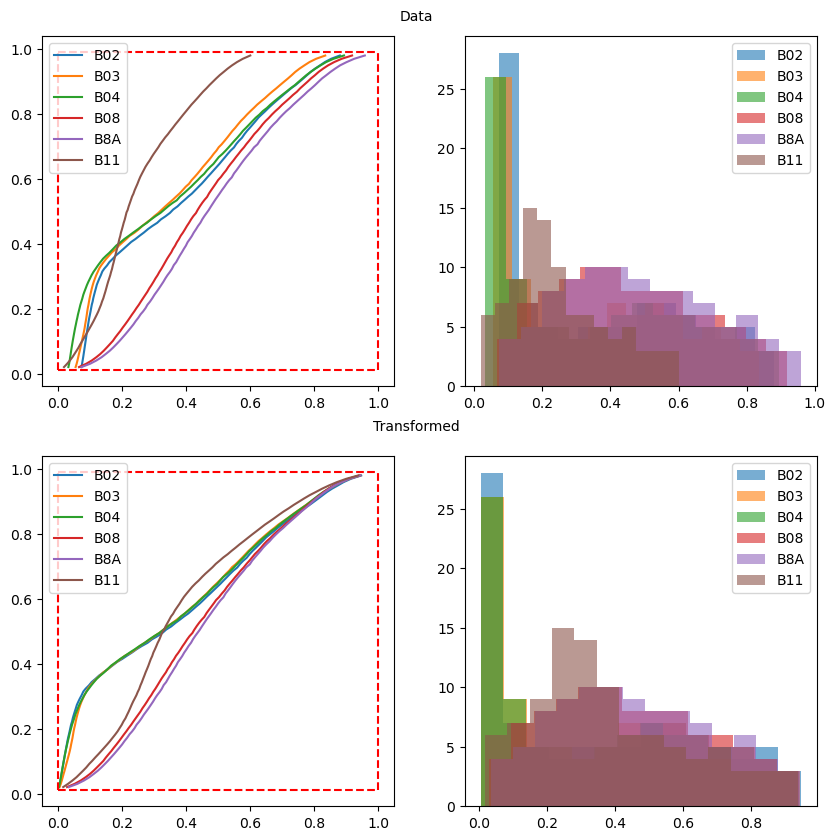

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

index_start = 2
index_end = -2
for i, quantile_list_ in enumerate([quantiles.T, quantiles_transformed]):
    ax_cdf, ax_hist = axs[i]
    for qu, cdf, band in zip(quantile_list_, cdf_list, config["bands"]):
        ax_cdf.plot(qu[index_start:index_end], cdf[index_start:index_end], label=band)
        ax_hist.hist(qu[index_start:index_end], bins=int(np.sqrt(96)*1.5), ec=None, alpha=0.6, label=band)

    ax_cdf.hlines([Scaler.minquantile, Scaler.maxquantile], Scaler.valmin, Scaler.valmax, colors='r', linestyles='--')
    ax_cdf.vlines([Scaler.valmin, Scaler.valmax], Scaler.minquantile, Scaler.maxquantile, colors='r', linestyles='--')
    ax_cdf.legend()
    ax_hist.legend()

plt.figtext(0.5, 0.9, 'Data', ha='center', va='center')
plt.figtext(0.5, 0.49, 'Transformed', ha='center', va='center')

Down the river, we have to use our scaler again.
Hence, we store it to disk.

In [9]:
Scaler.save()